In [ ]:
# compute cluster energy resolution
import os
import glob
import uproot
import awkward as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import helper functions
from root_data_loader import load_root_file_chunked, validate_cluster_counts, flatten_to_dataframe

# ============================================================================
# Load and prepare data (with chunking)
# ============================================================================

# Configuration
file_pattern = "/mnt/nvme0n1p4/HEP/Work/Project-W-Z/MotorHead/quicktree2histo/plot-recoil/root-files/outTree_zmumu_withPU_merged.root"
tree_name = "treeAnaWZ"
branches = ["fCluster_truthE", "fCluster_rawE", "fCluster_calE", "fCluster_MLE"]
n_events = 100000
chunk_size = 10000

# Branch mapping
branch_mapping = {
    "fCluster_truthE": "fCluster_truthE",
    "fCluster_rawE": "fCluster_rawE",
    "fCluster_calE": "fCluster_calE",
    "fCluster_MLE": "fCluster_MLE"
}

# Process all chunks and concatenate
all_dfs = []
for chunk_arr in load_root_file_chunked(file_pattern, tree_name, branches, 
                                        chunk_size=chunk_size, n_events=n_events):
    # Validate cluster counts
    validate_cluster_counts(chunk_arr, branches)
    
    # Flatten to DataFrame
    df_chunk = flatten_to_dataframe(chunk_arr, branch_mapping)
    
    # Filter and add response columns
    mask_valid = np.isfinite(df_chunk["fCluster_truthE"]) & (df_chunk["fCluster_truthE"] > 0)
    df_chunk = df_chunk.loc[mask_valid].reset_index(drop=True)
    df_chunk["response_em"] = df_chunk["fCluster_rawE"] / df_chunk["fCluster_truthE"]
    df_chunk["response_lc"] = df_chunk["fCluster_calE"] / df_chunk["fCluster_truthE"]
    df_chunk["response_ml"] = df_chunk["fCluster_MLE"] / df_chunk["fCluster_truthE"]
    
    all_dfs.append(df_chunk)

# Concatenate all chunks
df = pd.concat(all_dfs, ignore_index=True)
print(f"DataFrame shape: {df.shape}")

Loading file: /mnt/nvme0n1p4/HEP/Work/Project-W-Z/MotorHead/quicktree2histo/plot-recoil/root-files/outTree_zmumu_withPU_merged.root
Total events available: 262606
Reading 100000 events in chunks of 10000
  Loaded events 0-10000


AxisError: axis=1 exceeds the depth of this array (1)

In [27]:
def relative_resolution_68(x):
    median = np.median(x)
    q16 = np.percentile(x, 16)
    q84 = np.percentile(x, 84)
    return (q84 - q16) / (2 * median)


# choose log bins (adjust edges to your energy units)
#bin_centers = np.sqrt(np.array(bin_edges[:-1]) * np.array(bin_edges[1:]))og_energy_bins = np.logspace(1, 5, 21)  # 20 bins from 10^1 to 10^5
#bin_centers = np.sqrt(log_energy_bins[:-1] * log_energy_bins[1:])

bin_edges = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000,
             1200, 1400, 1600, 1800, 2000, 2500, 3000, 4000, 5000,
             6000, 8000, 10000]
bin_centers = np.sqrt(np.array(bin_edges[:-1]) * np.array(bin_edges[1:]))

sigma_em, sigma_lc, sigma_ml = [], [], []
for low, high in zip(bin_edges[:-1], bin_edges[1:]):  # use bin_edges, not log_energy_bins
    mask = (df["fCluster_truthE"] >= low) & (df["fCluster_truthE"] < high)
    sigma_em.append(relative_resolution_68(df.loc[mask, "response_em"]))
    sigma_lc.append(relative_resolution_68(df.loc[mask, "response_lc"]))
    sigma_ml.append(relative_resolution_68(df.loc[mask, "response_ml"]))

bin_centers = np.array(bin_centers)
sigma_em = np.array(sigma_em)
sigma_lc = np.array(sigma_lc)
sigma_ml = np.array(sigma_ml)

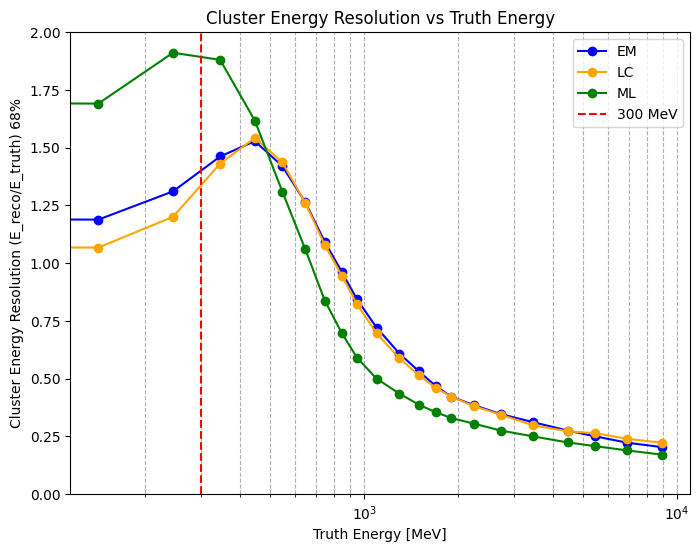

In [45]:
# plot the resolutions
plt.figure(figsize=(8,6))
plt.plot(bin_centers, sigma_em, label='EM', marker='o', color='blue')
plt.plot(bin_centers, sigma_lc, label='LC', marker='o', color='orange')
plt.plot(bin_centers, sigma_ml, label='ML', marker='o', color='green')
# put a line at 300 MeV
plt.axvline(x=300, color='r', linestyle='--', label='300 MeV')
plt.yscale('linear')  # ensure linear y-axis
# make x-axis in log scale
plt.ylim(0, 2.0)
plt.xscale('log')
plt.xlabel('Truth Energy [MeV]')
plt.ylabel('Cluster Energy Resolution (E_reco/E_truth) 68%')
plt.title('Cluster Energy Resolution vs Truth Energy')
plt.legend()
plt.grid(True, which="both", ls="--", axis='x')
plt.savefig("cluster_energy_resolution.png")
plt.show()

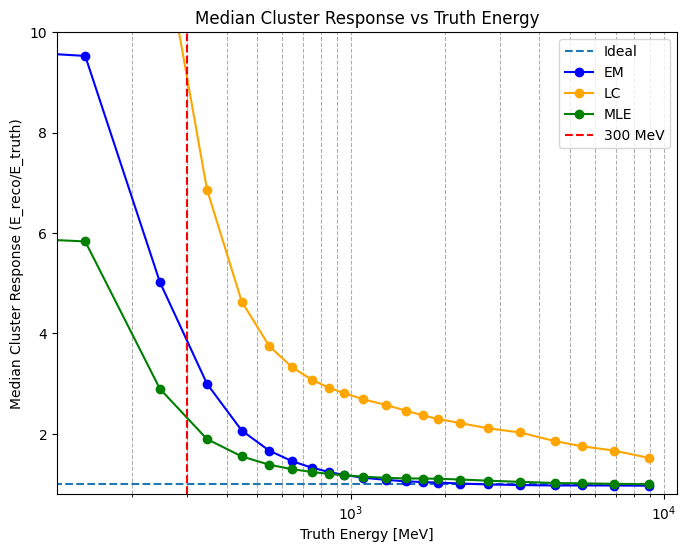

In [47]:
# plot median responses vs truth energy

median_em = []
median_lc = []
median_ml = []

for low, high in zip(bin_edges[:-1], bin_edges[1:]):  # use bin_edges, not log_energy_bins
    mask = (df["fCluster_truthE"] >= low) & (df["fCluster_truthE"] < high)
    median_em.append(np.median(df.loc[mask, "response_em"]))
    median_lc.append(np.median(df.loc[mask, "response_lc"]))
    median_ml.append(np.median(df.loc[mask, "response_ml"]))

median_em = np.array(median_em)
median_lc = np.array(median_lc)
median_ml = np.array(median_ml)

plt.figure(figsize=(8,6))
plt.semilogx(bin_centers, np.ones_like(bin_centers), label="Ideal", linestyle="--")
plt.semilogx(bin_centers, median_em, label="EM", marker="o", color="blue")
plt.semilogx(bin_centers, median_lc, label="LC", marker="o", color="orange")
plt.semilogx(bin_centers, median_ml, label="MLE", marker="o", color="green")
# make a line at 300 MeV
plt.axvline(x=300, color='r', linestyle='--', label='300 MeV')
plt.yscale('linear')  # ensure linear y-axis
plt.xlabel('Truth Energy [MeV]')
plt.ylabel('Median Cluster Response (E_reco/E_truth)')
plt.title('Median Cluster Response vs Truth Energy')
plt.ylim(0.8, 10)
plt.legend()
plt.grid(True, which="both", ls="--", axis='x')
plt.savefig("cluster_median_response.png")
plt.show()

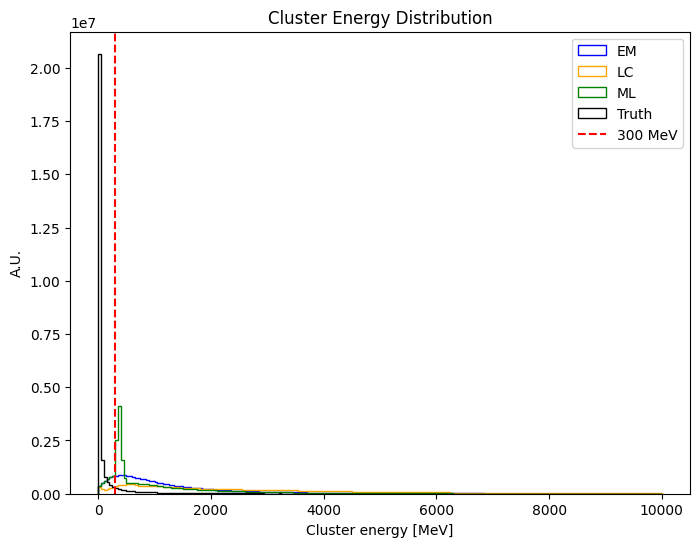

In [48]:
# plot histogram of cluster energy at different scales

min_energy = 0
max_energy = 10000
n_bins = 200


plt.figure(figsize=(8,6))
plt.hist(df["fCluster_rawE"], bins=n_bins, range=(min_energy,max_energy), histtype='step', label='EM', color='blue')#, density=True)
plt.hist(df["fCluster_calE"], bins=n_bins, range=(min_energy,max_energy), histtype='step', label='LC', color='orange')#, density=True)
plt.hist(df["fCluster_MLE"], bins=n_bins, range=(min_energy,max_energy), histtype='step', label='ML', color='green')#, density=True)
plt.hist(df["fCluster_truthE"], bins=n_bins, range=(min_energy,max_energy), histtype='step', label='Truth', color='black')#, density=True)
plt.axvline(x=300, color='r', linestyle='--', label='300 MeV')
#plt.yscale('log')
plt.xlabel('Cluster energy [MeV]')
plt.ylabel('A.U.')
plt.title('Cluster Energy Distribution')
plt.legend()
#plt.yscale('log')
#plt.xscale('log')
#plt.grid(True, which="both", ls="--", axis='x')
plt.savefig("cluster_energy_distribution.png")
# make a line at 300 MeV
plt.show()

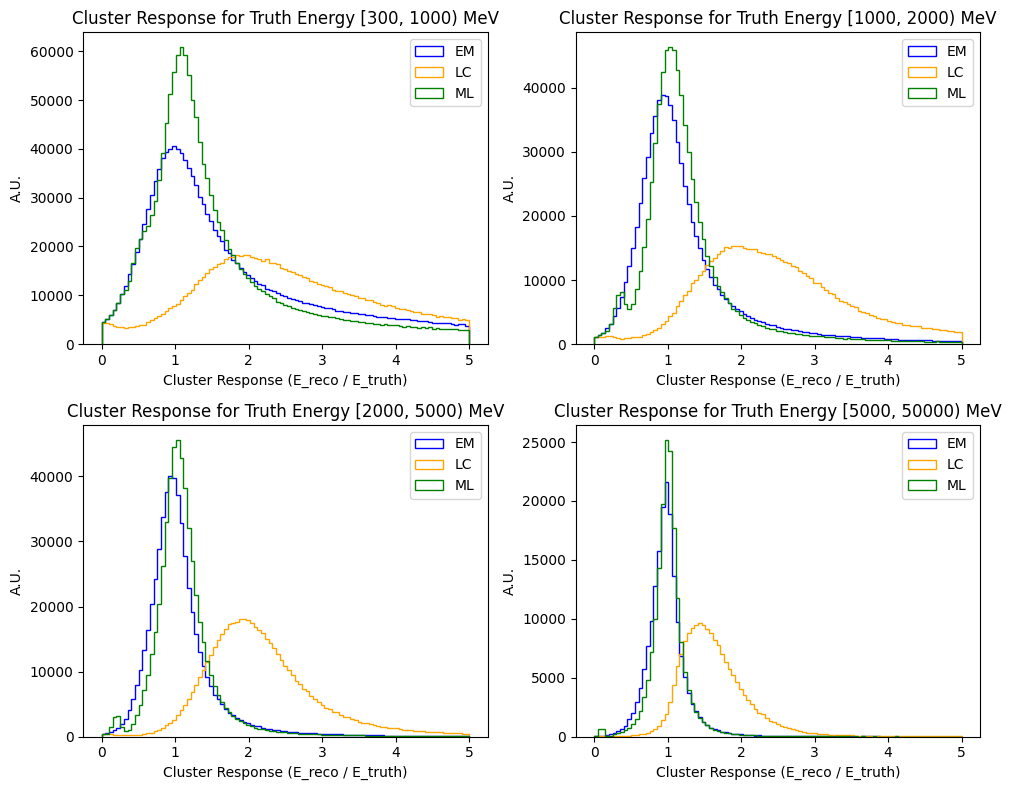

In [49]:
## plot cluster response (E_reco / E_truth) histograms at different energy slices
# use finer binning of 50 MeV
energy_slices = [(300, 1000), (1000, 2000), (2000, 5000), (5000, 50000)]
#energy_slices = [(0, 50000)]
bins_response = np.linspace(0, 5, 100)  # finer bins for response
plt.figure(figsize=(10, 8))
for i, (low, high) in enumerate(energy_slices):
    mask = (df["fCluster_truthE"] >= low) & (df["fCluster_truthE"] < high)
    plt.subplot(2, 2, i+1)
    plt.hist(df.loc[mask, "response_em"], bins=bins_response, histtype='step', label='EM', color='blue')#, density=True)
    plt.hist(df.loc[mask, "response_lc"], bins=bins_response, histtype='step', label='LC', color='orange')#, density=True)
    plt.hist(df.loc[mask, "response_ml"], bins=bins_response, histtype='step', label='ML', color='green')#, density=True)
    plt.xlabel('Cluster Response (E_reco / E_truth)')
    plt.ylabel('A.U.')
    plt.title(f'Cluster Response for Truth Energy [{low}, {high}) MeV')
    plt.legend()
plt.tight_layout()
plt.savefig("cluster_response_slices_1.png")
plt.show()

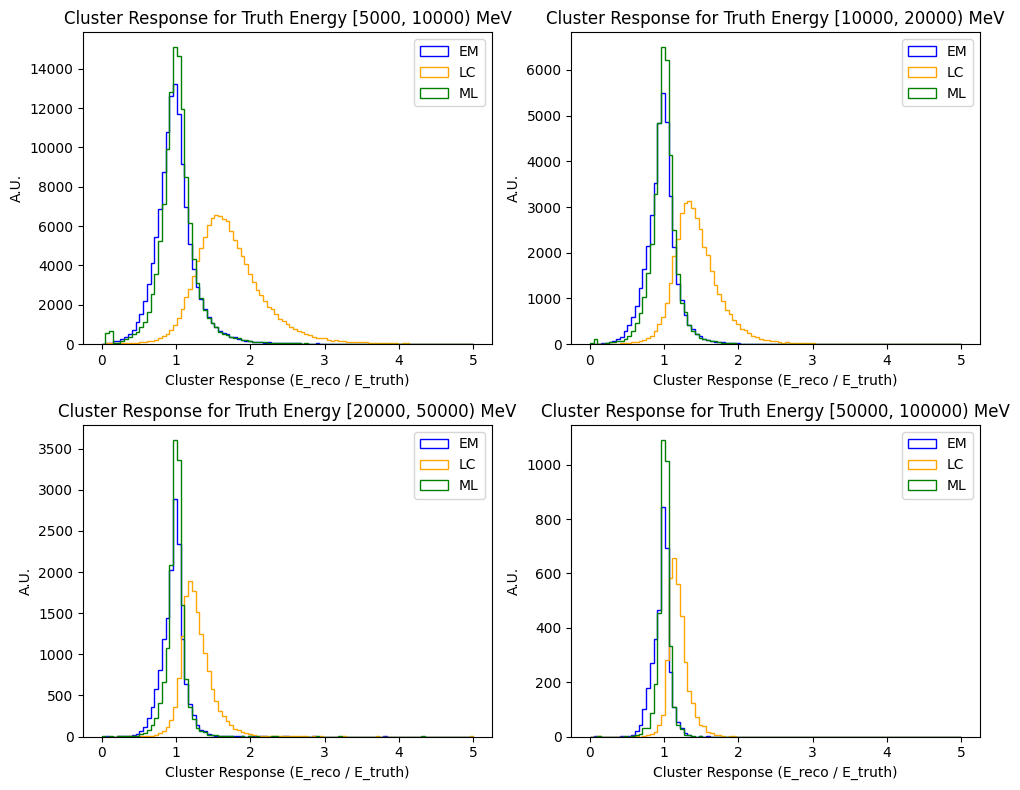

In [50]:
# more plots 
# use finer binning of 50 MeV
energy_slices = [(5000, 10000), (10000, 20000), (20000, 50000), (50000, 100000)]
#energy_slices = [(0, 50000)]
bins_response = np.linspace(0, 5, 100)  # finer bins for response
plt.figure(figsize=(10, 8))
for i, (low, high) in enumerate(energy_slices):
    mask = (df["fCluster_truthE"] >= low) & (df["fCluster_truthE"] < high)
    plt.subplot(2, 2, i+1)
    plt.hist(df.loc[mask, "response_em"], bins=bins_response, histtype='step', label='EM', color='blue')#, density=True)
    plt.hist(df.loc[mask, "response_lc"], bins=bins_response, histtype='step', label='LC', color='orange')#, density=True)
    plt.hist(df.loc[mask, "response_ml"], bins=bins_response, histtype='step', label='ML', color='green')#, density=True)
    plt.xlabel('Cluster Response (E_reco / E_truth)')
    plt.ylabel('A.U.')
    plt.title(f'Cluster Response for Truth Energy [{low}, {high}) MeV')
    plt.legend()
plt.tight_layout()
plt.savefig("cluster_response_slices_2.png")
plt.show()

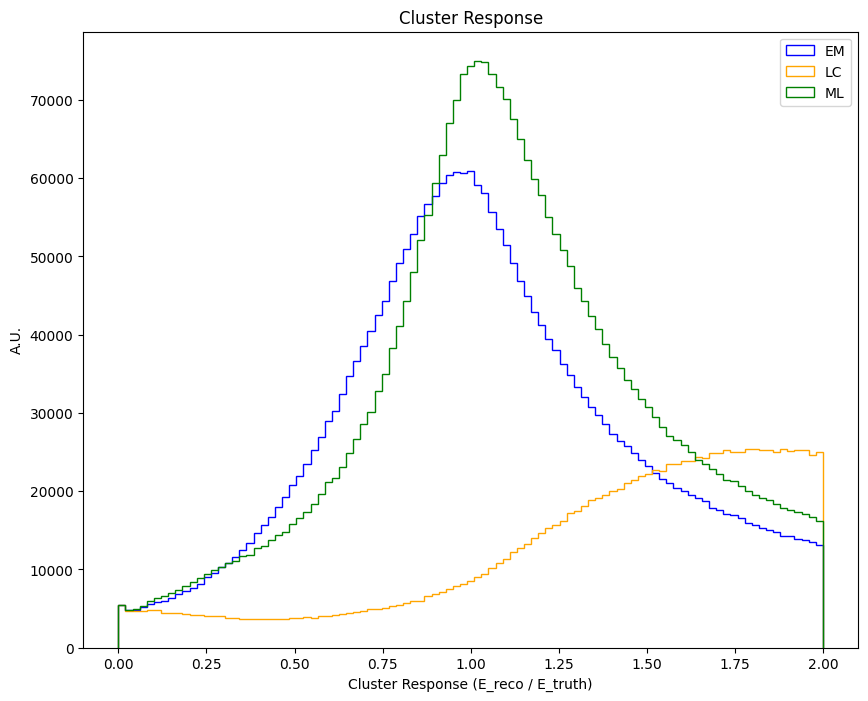

In [51]:
## plot cluster response (E_reco / E_truth) histograms at different energy slices
# use finer binning of 50 MeV
bins_response = np.linspace(0, 2, 100)  # finer bins for response
plt.figure(figsize=(10, 8))
low = 0
high = 50000
mask = (df["fCluster_truthE"] >= low) & (df["fCluster_truthE"] < high)
plt.hist(df.loc[mask, "response_em"], bins=bins_response, histtype='step', label='EM', color='blue')#, density=True)
plt.hist(df.loc[mask, "response_lc"], bins=bins_response, histtype='step', label='LC', color='orange')#, density=True)
plt.hist(df.loc[mask, "response_ml"], bins=bins_response, histtype='step', label='ML', color='green')#, density=True)
plt.xlabel('Cluster Response (E_reco / E_truth)')
plt.ylabel('A.U.')
plt.title(f'Cluster Response')
plt.legend()
plt.savefig("cluster_response.png")
plt.show()